# <center> Mesh Generation for Complex Geological Models</center>

This notebook is prepared to explain the required steps for making mesh in a very complex geological setting.<br>
The model is similar to the DeepStor model addressed in https://gmd.copernicus.org/preprints/gmd-2023-105/#discussion:<br><br>
<img src="Visualizations/paper_screenshot.jpg" title="paper_screenshot" width=50%>
<br>
The _x_ and _y_ extension of the presented example is the same as the DeepStor model but _z_ values of the real model are replaced by randomly generated data. From the complexity point of view, presented example is the same as the real DeepStor model.<br>
***
Here, it is tried to explain all the details of each cell and line of code. However, in case of any question <br> please contact ali.dashti@kit.edu.

In [12]:
# importing the required libraries:
import numpy as np
import math
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

***
The csv file imported in following cell contains a regular 3D point grid. First column is the _x_, second is _y_ and third column is _z_. <br>
Points are generated randomly and are not related to any real geological setting.

In [13]:
vertices = np.loadtxt("data/vertices_high_res.csv", delimiter=",")

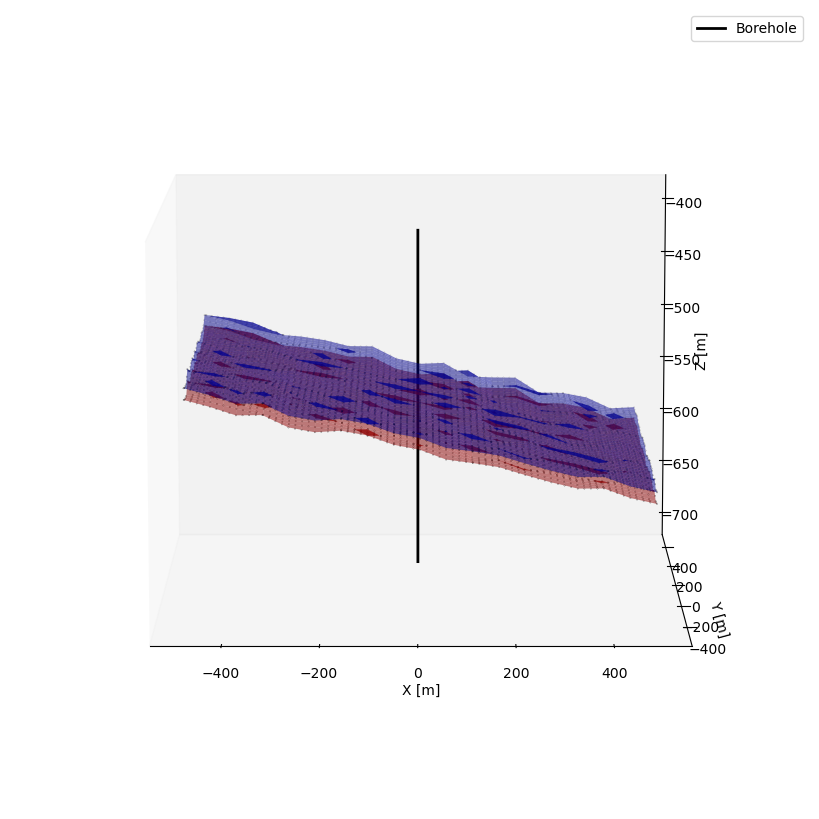

In [14]:
'''
This cell visualizes a 3D view on the thin layer. 
The layers is a more complicated version of the DeepStor's reservoir.
Nothing complicated is happening in this cell. We should only prepare the 
coordinate (x, y and z) values in a way to be applicable for a 3D plot via matplotlib.
'''
nx = np.unique (vertices[:,0], return_counts=True)[1][0] // 2 # grid's resoultion in x direction
ny = np.unique (vertices[:,1], return_counts=True)[1][0] // 2 # grid's resoultion in y direction
fig = plt.figure()
ax = fig.add_subplot (111, projection="3d")
fig.set_size_inches(8,8)                
fig.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=None,hspace=None)
x = vertices[:len(vertices)//2,0].reshape(-1,nx) # x values to be plotted (top and bottom contacts have the same x values)
y = vertices[:len(vertices)//2,1].reshape(ny,-1) # y values to be plotted (top and bottom contacts have the same y values)
z_up = vertices[:len(vertices)//2,2].reshape(ny,-1) # z values of the top contact of the reservoir
z_down = vertices[len(vertices)//2:,2].reshape(ny,-1) # z values of the bottom contact of the reservoir
ax.scatter3D(x,y,z_up, color='k', marker=".", s=0.1) # points from the upper contact
ax.scatter3D(x,y,z_down, color='k', marker=".", s=0.1) # points from the lower contact
ax.plot_surface(x, y, z_up, color='b', alpha=0.5) # upper contact
ax.plot_surface(x, y, z_down, color='r', alpha=0.5) # lower contact
ax.plot([0 ,0], [0 ,0],[-400,-700], c='k', lw=2, label='Borehole') # a borhole in the middle of the model
ax.set_xlabel('X [m]'); ax.set_ylabel('Y [m]'); ax.set_zlabel('Z [m]')
# ax.set_zlim3d(-1000,-0)
ax.grid(None)
ax.view_init(10, 270)
ax.ticklabel_format(useOffset=False)
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

The following steps describe what happens in the function named *fault_embedder*:
1. Start working only on the top surface because top and bottom surfaces are parallel. A simplified 2D view on the surface points is shown in the following animation. The simplified model has 50 points arranged in a regular grid.
2. Position of the fault should be defined. *fault_index* is the variable defining where the fault should go. The following animation shows what this variable mean and how it works. There are 10 grid point in the _x_ direction starting from 0 to 9. In the animation the *fault_index* is set to be 6.
3. After defining the location of the fault, the top surface will divide into two splits named as _left_array_faulted_ and _right_array_faulted_.
4. Then, we need to guarantee that the split pass through the fault plane. This overlap area is highlighted in the following animation.
5. Steps 2 and 3 should be repeated for the bottom surface which is 10 m deeper.
6. The *off_set* variable defines vertical displacement between splits of each surface. For example the top surface includes split 1 and split 2. These two surfaces have some overlaps and are separated by the *off_set* value in _z_ direction.
7. The generated point grid should be a numpy array stroing the _x_, _y_ and _z_ values from all the splits. But, we should know the length of each split, i.e. referred as *length_splits* in the function. 


<img src="Visualizations/overlap_area.gif" title="Fault in the model" width=50%>

In [15]:
def fault_embedder(fault_index, off_set, thickness, vertices, overlap_area):
    '''
    This function is displacing the reservoir layer as far as requested (by off_set value).
    sep: defines the location of the vertical fault. This values refers to the index
    of the array that we want to put the fault there. 
    off_set: how much the fault will displace the layer.
    thickness: thickness of the reservoir layer. 
    vertices: the 3D point grid representing the top and bottom surfaces of the reservoir layer.
    overlap_area: to make sure that splits of the surfaces passes through the fault plane.
    '''
    n_points = len(vertices) # how many points  stored in the vertices of the reservoir layer
    top_surface = vertices[:n_points//2, :] # we only work with the top surface because surfaces are parallel
    y_res = np.unique(top_surface[:,0],return_counts=True)[1][0] # how many points exist in y direction
    x_res = np.unique(top_surface[:,1],return_counts=True)[1][0] # how many points exist in x direction

    left_array_faulted = y_res * (x_res-fault_index)# this is the location of the fault!
    right_array_faulted = y_res * (x_res-(fault_index+overlap_area))# this is the overlap we consider  in two sides
    # of the fault to make sure that the splits of the top and bottom surface will pass throught the fault surface
    split1 = copy.deepcopy (top_surface[:left_array_faulted,:])# x, y and z of the grid points
    # of the TOP surface in the LEFT side of the fault or as called here split 1
    split2 = copy.deepcopy (top_surface[right_array_faulted:,:])# x, y and z of the grid points
    # of the TOP surface in the RIGHT side of the fault or as called here split 2
    
    bottom_surface = copy.deepcopy (top_surface) # from here we do what we did for the top surface
    bottom_surface[:,2] -= thickness # this is the bottom surface
    split3 = copy.deepcopy (bottom_surface[:left_array_faulted,:])# x, y and z of the grid points
    # of the BOTTOM surface in the LEFT side of the fault or as called here split 3
    split4 = copy.deepcopy (bottom_surface[right_array_faulted:,:])# x, y and z of the grid points
    # of the BOTTOM surface in the RIGHT side of the fault or as called here split 4
    
    if fault_index <= 34: 
        '''
        34 is the index location of the borhole. In the animation presented in the previous
        cell the boreholes location index is 3. We are assuming a normal vertical fault
        in the model and also we are certain about the reservoir's depth in the 
        borehole location. When the fault index is higher than 34 (exactly like the animation
        in revious cell) the left right hand side splits will be considered as the 
        hanging wall of the normal fault and be moved up to the off_set value down. But,
        if we set the fault index to lower than 34 it means that the fault comes in the eastern
        side of the borehole. Still we cannot change the depth where the borehole touches 
        the reservoir. Instead, the left hand side of the fault will be pushed up.
        '''
        last_z = split1[left_array_faulted-2*y_res:left_array_faulted-y_res,-1]
        split1[-y_res:,-1] = last_z
        split1[-2*y_res:-y_res,-1] = last_z
        
        split2[:,2] += off_set
        first_z = split2[2*y_res:3*y_res,-1]
        split2[:y_res,-1] = first_z
        split2[y_res:y_res*2,-1] = first_z

        last_z_d = split3[left_array_faulted-2*y_res:left_array_faulted-y_res,-1]
        split3[-y_res:,-1] = last_z_d
        split3[-2*y_res:-y_res,-1] = last_z_d

        
        split4[:,2] += off_set
        first_z_d = split4[2*y_res:3*y_res,-1]
        split4[:y_res,-1] = first_z_d
        split4[y_res:y_res*2,-1] = first_z_d
        
    else:
        last_z = split1[left_array_faulted-2*y_res:left_array_faulted-y_res,-1]
        split1[-y_res:,-1] = last_z
        split1[-2*y_res:-y_res,-1] = last_z
        split1[:,2] -= off_set
        
        first_z = split2[2*y_res:3*y_res,-1]
        split2[:y_res,-1] = first_z
        split2[y_res:y_res*2,-1] = first_z

        last_z_d = split3[left_array_faulted-2*y_res:left_array_faulted-y_res,-1]
        split3[-y_res:,-1] = last_z_d
        split3[-2*y_res:-y_res,-1] = last_z_d
        split3[:,2] -= off_set
        
        first_z_d = split4[2*y_res:3*y_res,-1]
        split4[:y_res,-1] = first_z_d
        split4[y_res:y_res*2,-1] = first_z_d 
    length_splits = np.array([len(split1), len(split2), len(split3), len(split4)]) # this list defines length 
    # of each split
    
    x = np.mean([split1[-1,0], split2[0,0]]) # the x coordinate of the vertical fault which will be in the middle of
    # the overlap area
    y_min = np.min (split1[:,1]) # the minimum y coordinate of the vertical fault
    y_max = np.max (split1[:,1]) # the maximum y coordinate of the vertical fault
    
    point_grid = np.vstack([split1, split2, split3, split4])

    fault_corners = np.array([[x, y_min, -1000], [x, y_max, -1000], [x, y_max, 0], [x, y_min, 0]])
    return (point_grid, fault_corners, length_splits)

overlap_area = 5 # the meaning of this variable is explained via the previous animation
'''
We also needed to define the location of the well in our model.
The previous animation showed how it works. in the following you can try different fault_index values
and see where the fault will be located. In front of the each index, the distance of the fault from the
well is written.
Another animation in the next cell also renders the fault embeddment process in a simple schematic.
'''
fault_index = 27 # 98.5 m in the east of the well
# fault_index = 26 # 112 m in the east of the well
# fault_index = 28 # 85 m in the east of the well
# fault_index = 29 # 71 m in the east of the well
# fault_index = 30 # 58 m in the east of the well
# fault_index = 31 # 45 m in the east of the well
# fault_index = 32 # 31 m in the east of the well
# fault_index = 33 # 18 m in the ease of the well
# fault_index = 34 # 4 m in the east of the well
# fault_index = 35 # 8 m in the west of the well
# fault_index = 36 # 22 m in the west of the well
# fault_index = 37 # 35 m in the west of the well
# fault_index = 38 # 48 m in the west of the well
# fault_index = 42 # 100 m in the west of the well
point_grid, fault_corners, length_splits = fault_embedder(fault_index, -25, 10, vertices, overlap_area)
print (fault_corners[0][0])

98.55357142852154


The following animation shows how steps of the *fault_embedder* are working.


<img src="Visualizations/fault_embeddment.gif" title="Fault embeddment" width=40%>

***
In the following another simplified example is presented to clarify how the fault has been defined in the base case of the DeepStor.<br>
The points making the top and bottom surfaces of the reservoir layers are visualized as black dots and rectangles, respectively.<br>
To make the visualization more undrestandable, the top of the reservoir layers is split into small patches numbered. In reality, only one single continuous surface exists for either the top or the bottom of the reservoir and patches are drawn here only for the sake of visualization. The same number of points and patches (only with a different color) are shown for the bottom of the reservoir in the base case. Making mesh for such case is already elaborated in https://github.com/Ali1990dashti/GeoMeshPy/blob/main/Examples/No_Fault/Four_Layers.ipynb.
In short, all the points can be imported into the mesh generator (_GMSH_) and then a mesh with desired surfaces can be generated.<br>
***
- It is important to highlight it again: surafces are generated in a way to fit the __points__ (black dots and triangles) and the patches are only here to make the visualization easier to undrestand.

<h2><center>The simplified base case</center></h2>
<img src="Visualizations/base_case.jpg" title="The simplified base case" width=50%>

***
Then, introduced model in https://gmd.copernicus.org/preprints/gmd-2023-105/#discussion added a fault with constant displacement to the base case of the DeepStor. In the introduced function (*fault_embedder*) did it for us as the following:
1. The fault's location wa defined in the model by user. This way, the fault is dividing either the top or the bottom contact of the reservoir into two splits. For both the contacts one split (the left hand side of the fault surface).
2. For the sake of simplicity, this example works with a constant displacement which is also higher then the reservoir thickness.
3. Extra patches (hashed ones) will be generated to make sure that the splits pass through the fault surface. For the first split of top contact that located in the left hand side of the fault, point numbers 13, 14, and 15 allow us to make it. As mentioned befor, the mesh generator will make the surface based on any shape of the imported point cloud. To create this first split, 15 points should be imported to the mesh generator. For the second split of the top contact, 12 points (7 to 18) are required.
4. Finally, coordinates of the points that make four splits are resulted from the function.

<h2><center>The faulted case</center></h2>
<img src="Visualizations/faulted_case.jpg" title="The faulted case" width=50%>

***
The next cell prepares the splits of the layers to be plotted. <br>
We started with a continuous array that coordinates of the both top and bottom contacts were stored there. Then, one fault came into the model and made four splits.<br>
*point_grid* array contains the _x_, _y_ and _z_ values of the all points (6396) that make the top and bottom surfaces of the thin reservoir.
*fault_corners* is another array that stores the coordinates of the fault. It contains four points that if you connect them, a vertical fault plane will be generated.

*length_splits* defines the length of each split. If you print it, it will be the following array:<br><br>
_array([1927, 1271, 1927, 1271])_<br><br>
This array says the first split has 1927 points. For the second one 1271 points are generated. These two first splits are making the upper contact and the last two numbers (again 1927 and 1271) say how many points exist in each split of the bottom contact.
***
The next cell uses *point_grid* and *length_splits* to prepared the points for being plotted in the cell after.

In [5]:
where_to_break = np.cumsum(length_splits) # this will tell us where the splits happen in the point grid
split1 = point_grid[:where_to_break[0], :]
split2 = point_grid[where_to_break[0]:where_to_break[1], :]
split3 = point_grid[where_to_break[1]:where_to_break[2], :]
split4 = point_grid[where_to_break[2]:, :]

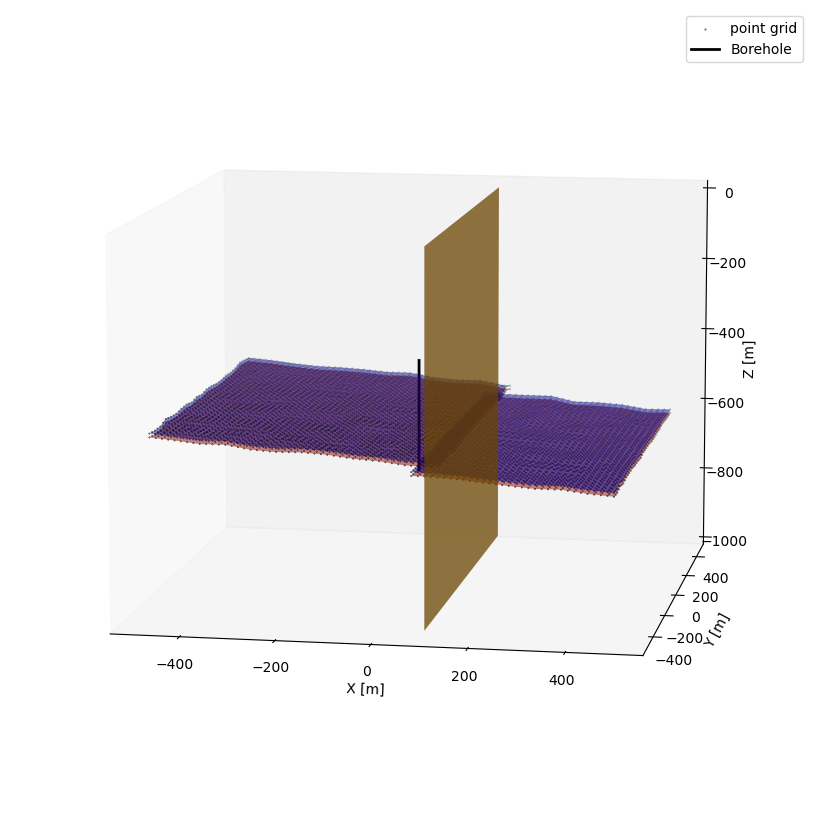

In [6]:
fig = plt.figure()
ax = fig.add_subplot (111, projection="3d")
fig.set_size_inches(8,8)                
fig.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=None,hspace=None)
ny_left = np.unique (split1[:,0], return_counts=True)[1][0] # grid's resoultion in y direction
nx_left = np.unique (split1[:,1], return_counts=True)[1][0] # grid's resoultion in x direction
ny_right = np.unique (split2[:,0], return_counts=True)[1][0] # grid's resoultion in y direction
nx_right = np.unique (split2[:,1], return_counts=True)[1][0] # grid's resoultion in x direction

x_left = split1[:,0].reshape(-1,ny_left) # x values to be plotted (top and bottom contacts have the same x values)
y_left = split1[:,1].reshape(nx_left,-1) # y values to be plotted (top and bottom contacts have the same y values)
x_right = split2[:,0].reshape(-1,ny_right) # x values to be plotted (top and bottom contacts have the same x values)
y_right = split2[:,1].reshape(nx_right,-1) # y values to be plotted (top and bottom contacts have the same y values)

z_up_left = split1[:,2].reshape(nx_left,-1) # z values of the top contact of the reservoir
z_down_left = split3[:,2].reshape(nx_left,-1) # y values of the top contact of the reservoir
z_up_right = split2[:,2].reshape(nx_right,-1) # z values of the top contact of the reservoir
z_down_right = split4[:,2].reshape(nx_right,-1) # y values of the top contact of the reservoir

ax.scatter3D(point_grid[:,0],point_grid[:,1],point_grid[:,2], color='k', s=0.1, label='point grid') # the whole point grid
ax.plot_surface(x_left, y_left, z_up_left, color='b', alpha=0.5) # upper contact
ax.plot_surface(x_left, y_left, z_down_left, color='r', alpha=0.5) # lower contact
ax.plot_surface(x_right, y_right, z_up_right, color='b', alpha=0.5) # upper contact
ax.plot_surface(x_right, y_right, z_down_right, color='r', alpha=0.5) # lower contact

ax.plot_surface(np.array([[fault_corners[0,0], fault_corners[1,0]], [fault_corners[3,0], fault_corners[2,0]]]), 
                np.array([[fault_corners[0,1], fault_corners[1,1]], [fault_corners[3,1], fault_corners[2,1]]]),
                np.array([[fault_corners[0,2], fault_corners[1,2]], [fault_corners[3,2], fault_corners[2,2]]]), 
                color='orange', alpha=0.75) # fault plane
ax.plot([0 ,0],
        [0 ,0],[-400,-700], c='k', lw=2, label='Borehole') # a borhole in the middle of the model
ax.set_xlabel('X [m]'); ax.set_ylabel('Y [m]'); ax.set_zlabel('Z [m]')
ax.set_zlim3d(-1000,-0)
ax.grid(None)
ax.view_init(10, 280)
ax.ticklabel_format(useOffset=False)
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

If everything runs correctly the following plot should be resulted from the previous cell:
<img src="Visualizations/3D_meletta_model_faulted.jpg" title="Faulted model" width=50%>

***
The following aniation also shows a very simple visualization to clarify the idea behind presented works in https://gmd.copernicus.org/preprints/gmd-2023-105/#discussion:<br>
1. First let's make the geological model
2. Mesh the each model
3. Simulate the related variables e.g. temperature, pressure, concentration, etc. for each model

<h2><center>Updating the mesh</center></h2>
<img src="Visualizations/updating_mesh.gif" title="Updating the mesh" width=100%>

***
The next long cell takes care of several things such as:
1. Initializing GMSH and making a big box representing the domain
2. Importing 6400 point into GMSH
3. Making lines and rough surfaces passing through the point grids
4. Cutting the domain based on the existing surfaces
5. Defining multiple levels of the refinement on different elements in the domain
6. Meshing the geometry
7. Writing and exporting the mesh

In [7]:
import gmsh
import itertools
from itertools import chain
from math import atan2

def argsort(seq):
    '''
    This function sorts the exterior points in a clockwise order. In order to fit a surface to a point cloud 
    in GMSH, we nned to first make lines by connecting the boundary of the point cloud. Detailed visualizations 
    are available in 
    https://github.com/Ali1990dashti/GeoMeshPy/blob/main/Examples/Storage%20Model/Greater_Geneva_Basin_Mesh.ipynb
    '''
    return sorted(range(len(seq)), key=seq.__getitem__)
def rotational_sort(list_of_xy_coords, centre_of_rotation_xy_coord, clockwise=True):
    '''
    This function sorts the exterior points in a clockwise order. In order to fit a surface to a point cloud 
    in GMSH, we nned to first make lines by connecting the boundary of the point cloud. Detailed visualizations 
    are available in 
    https://github.com/Ali1990dashti/GeoMeshPy/blob/main/Examples/Storage%20Model/Greater_Geneva_Basin_Mesh.ipynb
    '''
    cx,cy = centre_of_rotation_xy_coord
    angles = [atan2(x-cx, y-cy) for x,y in list_of_xy_coords]
    indices = argsort(angles)
    if clockwise:
        return [list_of_xy_coords[i] for i in indices]
    else:
        return [list_of_xy_coords[i] for i in indices[::-1]]

    
########################-------------------------------------########################
'''
The next 10 variables define the characteristics of the surfaces that will pass through the point clouds.
GMSH uses these variables in the function called gmsh.model.occ.addSurfaceFilling().
'''
degree = 2
numPointsOnCurves = 10
numIter = 10
anisotropic = False
tol2d = 0.00001
tol3d = 0.1
tolAng = 1
tolCurv = 1
maxDegree = 3
maxSegments = 400


########################-------------------------------------########################
'''
Making a 3D box is the first step. The box has 8 points, 12 lines and 6 surfaces.
It is important to keep track of the tag number of each element in GMSH. The tag number acts as 
the index of that element. For example the number of the point of the box strart from 1 to 8.
For the lines tag numbers range from 1 to 12.
The size of the box should match the grid point. Looking into gmsh.model.occ.addBox() can help 
to undrestand how the values should be set for x, y, z, dx, dy and dz
'''
gmsh.initialize()
gmsh.model.occ.addBox(min(point_grid[:,0]),fault_corners[0][1],
                      fault_corners[0][2],max(point_grid[:,0])-min(point_grid[:,0]),
                      fault_corners[1][1]-fault_corners[0][1],
                      fault_corners[2][2]-fault_corners[0][2])


########################-------------------------------------########################
'''
This for loop adds four points to the model. These four points are corners of the fault surface.
The tag number of each point can be set manually but here we let the GMSH to assign tag numbers which
countinue from the last one. To make the box, 8 points were generated. Hence, the tag numbers starts 
from 9 and ends with 12 because the fault has 4 corner points

'''
for [x, y, z] in fault_corners:
    gmsh.model.occ.addPoint(x, y, z)

    
########################-------------------------------------########################
'''
The next list stores the tag number of the POINTS we created for the fault.
GMSH needs two points to creat a line. The following neste list stores tag number of the related
point pairs of the fault. The tag number of the four lines also starts from 13 and ends with 16. 
'''    
corner_fault_points = [[9, 10], [10, 11], [11, 12], [12, 9]]    
for pair in corner_fault_points:
    gmsh.model.occ.addLine (pair[0], pair[1])

    
########################-------------------------------------########################

'''
The next list stores the tag number of the LINES we created for the fault.
GMSH need four lines to creat a surface and the following list, i.e. fault_lines stores tag number of the lines that 
create the fault. Here we set the tag number of the created surface to be 7. 
'''  
fault_lines = [13, 14, 15, 16]
gmsh.model.occ.addCurveLoop(fault_lines, 7)
gmsh.model.occ.addSurfaceFilling(7, 7)


########################-------------------------------------########################
'''
The next lines of code split the grid pooints into related values. In the presented example
we expect to have four splits.
'''  
spl_num = np.cumsum(length_splits).tolist()[:-1] # each cloud of points is separated
spl_num = [int (i) for i in spl_num]
sep_ar = np.split(point_grid, spl_num) # it is a list composed of four arrays and each array represents one split 


########################-------------------------------------########################
'''
The next lines of code split the grid pooints into related values. In the presented example
we expect to have four splits.
''' 
l_tags = []
for ind, point_clouds in enumerate (sep_ar):
    splits_list = point_clouds.tolist()
    for [x, y, z] in splits_list: # this happens four times because we have four splits
        gmsh.model.occ.addPoint(x, y, z) # it creates each point of the grid point with 6396 points!
    y_sub = np.unique(point_clouds[:,1].round(5),return_counts=True)[1] # grid resolution in y direction
    x_sub = np.unique(point_clouds[:,0].round(5),return_counts=True)[1] # grid resolution in x direction
    pts = []
    for j in np.split (point_clouds, np.cumsum(x_sub)[:-1]):
        if (j[0] != j[-1]).any():
            pts.append([j[0], j[-1]]) # it finds and adds exterior point of the cloud to the list named pts
    for m in np.split (point_clouds[np.lexsort((point_clouds[:,0],point_clouds[:,1]))], np.cumsum(y_sub)[:-1]):
        if (m[0] != m[-1]).any():
            pts.append([m[0], m[-1]]) # it finds and adds exterior point of the cloud to the list named pts
    listed_pts = [[j.tolist() for j in i] for i in pts] # changes the arrays to lists
    merged_listed_pts = list(chain.from_iterable(listed_pts)) # merges the lists
    merged_tupled_pts = list(set(tuple(x) for x in merged_listed_pts)) # removes the duplicates
    unified_list_pts = [list(i) for i in merged_tupled_pts] # back to list
    unified_array_pts = np.array([sublist for sublist in unified_list_pts]) # changes the list to array
    sorted_array_pts = unified_array_pts[np.lexsort((unified_array_pts[:,1], unified_array_pts[:,0]))] # sort array
    ext_points = sorted_array_pts[:,0:-1].tolist() # back from array to the list
    arround_pts = rotational_sort(ext_points, (np.mean(np.array(ext_points)[:,0]),np.mean(np.array(ext_points)[:,1])),True)
    tags = np.where((point_clouds[:,:-1] == np.array(arround_pts)[:,None]).all(-1))[1] + 1
    l_tags.append(len(tags)) # this list now stores the tag number of the lines that make the exterior boundary
    # of the point cloud
    start_point = int (8+len(fault_corners)+np.sum(length_splits[0:ind]))
    start_line = int (12+len(fault_corners)+1+np.sum(l_tags[0:ind]))
    for i in range (len(tags)): # this for loop creates the exterior lines of each cloud
        if i != len(tags)-1:
            gmsh.model.occ.addSpline([tags[i]+start_point,tags[i+1]+start_point]) # it creates exterior lines
                                                               # of the points cloud
        else:
            gmsh.model.occ.addSpline([tags[i]+start_point,tags[0]+start_point]) # it creates exterior lines
                                                               # of the points cloud
    gmsh.model.occ.addCurveLoop([i for i in range (start_line, start_line+len(tags))], start_line*10) # this 
                               # curve loop collects all the exterior lines of the points cloud
    gmsh.model.occ.addSurfaceFilling(start_line*10, start_line*10,
                                     [m for m in range (start_point+1, start_point+np.max(tags))
                                      if m not in tags+start_point],
                                     degree,
                                     numPointsOnCurves,
                                     numIter,
                                     anisotropic,
                                     tol2d,
                                     tol3d,
                                     tolAng,
                                     tolCurv,
                                     maxDegree,
                                     maxSegments) # create surface by connecting exterior lines
                                                  # and inclding interior points

            
########################-------------------------------------########################
'''
Here two points are added which make the top and bottom of the borehole. Their tag number is arbitraryly set to be 
9999 and 10000. The line (tag=999) also connects these two points.
'''             
gmsh.model.occ.addPoint(0, 0, -400, tag=9999)
gmsh.model.occ.addPoint(0, 0, -700, tag=10000)
gmsh.model.occ.addLine (9999, 10000, tag=999)


########################-------------------------------------########################
gmsh.model.occ.synchronize() # this is where GMSH calls all the generated entities into the model.
gmsh.option.setNumber('Geometry.ToleranceBoolean', 0.1)

surfs = gmsh.model.occ.getEntities(2) # finds out tag number of the generated surfaces in the model
wells = [(1, 999)] # this is the address of the borehole we generated via gmsh.model.occ.addLine (9999, 10000, tag=999)
volumes = gmsh.model.occ.getEntities(3) # finds out tag number of the generated surfaces in the model
out_all = gmsh.model.occ.fragment(surfs + wells, volumes) # see https://gmsh.info/doc/texinfo/gmsh.html#Boolean-operations

########################-------------------------------------########################
'''
As mentioned earlier, we will have some redundancies in out geometry. For example the splits 
were extended toward the fault surface. The extra parts of the surfaces were shown via green colour in simple
schematic. Therefore, we need to ask GMSH to delet these redundancies and also keep some parts that we need like the
line representing the broehole.
'''  
curves_to_preserve = out_all[1][-2] # this way we keep the line that represents the borhole
gmsh.model.occ.synchronize()
points_to_preserve = gmsh.model.getBoundary(curves_to_preserve, combined=False)
entities_to_preserve = curves_to_preserve + points_to_preserve
entities = gmsh.model.getEntities()

########################-------------------------------------########################
'''
The next lines of code look into the all elements of the model and removes redundant surfaces, lines and points.
''' 
for e in entities:
    emb = gmsh.model.mesh.getEmbedded(e[0], e[1])
    gmsh.model.mesh.removeEmbedded([e])
    for p in entities_to_preserve:
        if p in emb:
            gmsh.model.mesh.embed(p[0], [p[1]], e[0], e[1])
gmsh.model.removeEntities(gmsh.model.getEntities(2), True)
gmsh.model.removeEntities(gmsh.model.getEntities(0))

########################-------------------------------------########################
'''
The next lines of code allow you to refine your mesh. Tens of refinement strategies are 
elaborated in https://gmsh.info/doc/texinfo/gmsh.html#Gmsh-mesh-size-fields.
Seleted refinement strategy can be customized based on the user's need.
'''  
gmsh.model.mesh.field.add("Distance", 1)
gmsh.model.mesh.field.setNumbers(1, "CurvesList", np.array(curves_to_preserve)[:,1].tolist())
gmsh.model.mesh.field.setNumber(1, "Sampling", 200)
gmsh.model.mesh.field.add("Threshold", 2)
gmsh.model.mesh.field.setNumber(2, "InField", 1)
gmsh.model.mesh.field.setNumber(2, "SizeMin", 5)
gmsh.model.mesh.field.setNumber(2, "SizeMax", 250)
gmsh.model.mesh.field.setNumber(2, "DistMin", 5.)
gmsh.model.mesh.field.setNumber(2, "DistMax", 400)
gmsh.model.mesh.field.add("Distance", 3)
gmsh.model.mesh.field.setNumbers(3, "SurfacesList", [7, 8, 15])
gmsh.model.mesh.field.setNumber(3, "Sampling", 200)
gmsh.model.mesh.field.add("Threshold", 4)
gmsh.model.mesh.field.setNumber(4, "InField", 3)
gmsh.model.mesh.field.setNumber(4, "SizeMin", 10)
gmsh.model.mesh.field.setNumber(4, "SizeMax", 250)
gmsh.model.mesh.field.setNumber(4, "DistMin", 10.)
gmsh.model.mesh.field.setNumber(4, "DistMax", 500)
gmsh.model.mesh.field.add("Distance", 5)
gmsh.model.mesh.field.setNumbers(5, "SurfacesList", [3, 13, 19, 23])
gmsh.model.mesh.field.setNumber(5, "Sampling", 200)
gmsh.model.mesh.field.add("Threshold", 6)
gmsh.model.mesh.field.setNumber(6, "InField", 5)
gmsh.model.mesh.field.setNumber(6, "SizeMin", 25)
gmsh.model.mesh.field.setNumber(6, "SizeMax", 250)
gmsh.model.mesh.field.setNumber(6, "DistMin", 25.)
gmsh.model.mesh.field.setNumber(6, "DistMax", 500)
gmsh.model.mesh.field.add("Distance", 7)
gmsh.model.mesh.field.setNumbers(7, "SurfacesList", [6, 28])
gmsh.model.mesh.field.setNumber(7, "Sampling", 200)
gmsh.model.mesh.field.add("Threshold", 8)
gmsh.model.mesh.field.setNumber(8, "InField", 7)
gmsh.model.mesh.field.setNumber(8, "SizeMin", 40)
gmsh.model.mesh.field.setNumber(8, "SizeMax", 250)
gmsh.model.mesh.field.setNumber(8, "DistMin", 40.)
gmsh.model.mesh.field.setNumber(8, "DistMax", 500)
gmsh.model.mesh.field.add("Min", 9)
gmsh.model.mesh.field.setNumbers(9, "FieldsList", [2, 4, 6, 8])
gmsh.model.mesh.field.setAsBackgroundMesh(9)
gmsh.option.setNumber("Mesh.MeshSizeMax", 250)
gmsh.option.setNumber("Mesh.Algorithm3D", 10)
gmsh.model.mesh.generate(3)
gmsh.write("mesh/geological_model.msh") # to make the mesh
gmsh.fltk.run() # to pop up the GMSH GUI
gmsh.clear() # to clear up the GMSH memory in your Jupyter notebook
gmsh.finalize()

***
If everything works fine, you can generate such nice views from the mesh:
<h2><center>Cross section</center></h2>
<img src="Visualizations/cross_view.jpg" title="Corss Section" width=50%>
<br><br>
<h2><center>Reservoir layer</center></h2>
<img src="Visualizations/reservoir_layer.jpg" title="Reservoir layer" width=50%>

<br><br>
In case of any questions, do not hesitate contacting me (ali.dashti@kit.edu) or opening an issue.
<br><br>
Cheers<br>
Ali